In [15]:
import pandas as pd
import zipfile
from scipy.spatial.distance import cdist
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
coord_df = pd.read_csv("../data/school_coordinates.csv")

coord_df[['Lat','Lon']] = coord_df.geo_coordinates.str.split(",", expand=True)

coord_df['Lat'] = coord_df['Lat'].astype('double')
coord_df['Lon'] = coord_df['Lon'].astype('double')

coord_df

In [ ]:
data_dir = "../data/rain/zip/"
filename = "gsmap_nrt.20150801.0000.05_AsiaSS.csv.zip"

date = filename.split('.')[1]
hour = filename.split('.')[2]

zf_path = data_dir + filename

zf = zipfile.ZipFile(zf_path) 
df = pd.read_csv(zf.open(filename[:-4]))
df.columns = ['Lat', 'Lon', 'RainRate', 'CalibratedRain']
df['date'] = date
df['hour'] = hour

df.head()

In [ ]:
def closest_point(point, points):
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    return df[df[col1] == x][col2].values[0]

df['point'] = [(x, y) for x,y in zip(df['Lat'], df['Lon'])]
coord_df['point'] = [(x, y) for x,y in zip(coord_df['Lat'], coord_df['Lon'])]

coord_df['closest'] = [closest_point(x, list(df['point'])) for x in coord_df['point']]
coord_df['RainRate'] = [match_value(df, 'point', x, ['RainRate', 'date', 'hour']) for x in coord_df['closest']]

coord_df

_df = coord_df[['slno', 'area', 'name_school', 'RainRate']]
_df

In [19]:
zip_list = glob.glob(data_dir + '*.csv.zip')

main_df = pd.DataFrame(columns = ['slno', 'RainRate'])
# already_date = main_df.date.unique().tolist()
# already_date

for i in tqdm(range(len(zip_list))):

    zf_path = zip_list[i]

    filename = zf_path.split('/')[-1]

    date = filename.split('.')[1]
    hour = filename.split('.')[2]

    # if date in already_date:
    #     continue

    zf = zipfile.ZipFile(zf_path) 
    df = pd.read_csv(zf.open(filename[:-4]))
    df.columns = df.columns.str.replace(' ', '')
    df['date'] = date
    df['hour'] = hour

    df['point'] = [(x, y) for x,y in zip(df['Lat'], df['Lon'])]
    coord_df['point'] = [(x, y) for x,y in zip(coord_df['Lat'], coord_df['Lon'])]

    coord_df['closest'] = [closest_point(x, list(df['point'])) for x in coord_df['point']]
    coord_df['RainRate'] = [match_value(df, 'point', x, ['RainRate', 'date', 'hour']) for x in coord_df['closest']]

    coord_df

    _df = coord_df[['slno', 'area', 'name_school', 'RainRate']]
    _df

    main_df = pd.concat([main_df, _df], axis = 0)


100%|██████████| 2928/2928 [1:12:55<00:00,  1.49s/it]


In [ ]:
main_df[['Rain','date', 'hour']] = pd.DataFrame(main_df.RainRate.tolist(), index= main_df.index)
main_df

In [21]:
main_df.to_csv("../data/rain/main.csv")

In [ ]:
plot_df = (
    main_df.assign(
        date = lambda d: pd.to_datetime(d.date + '' + d.hour)
    )
    .sort_values('date')
)
plot_df

In [ ]:
count_df = plot_df.groupby(level=0)['Rain'].count()

fig, ax = plt.subplots()
count_df.plot(kind="line", y="Rain", ax=ax, label=i)

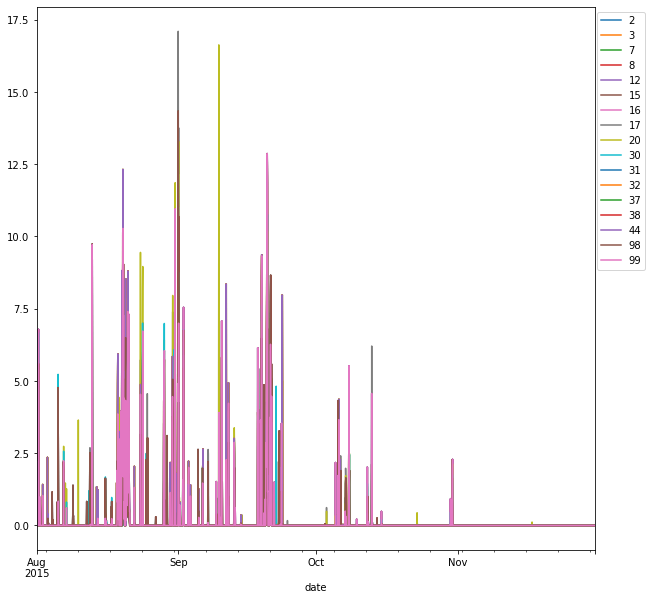

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
for i, g in plot_df.groupby("slno"):
    g.plot(kind="line", x = 'date', y="Rain", ax=ax, label=i)
lgd = ax.legend(loc = 1, bbox_to_anchor=(1.1, 1.0))

fig.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi = 300)

In [25]:
export_path = ""
main_df.to_csv(export_path)